In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import math
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

# Data

In [6]:
# Read data
path = '../../../data.csv'
motion = np.genfromtxt(path, delimiter=',', dtype=np.float64)
contacts = np.genfromtxt(path, delimiter=',', usecols=(46, 47), dtype=bool)

In [7]:
motion.shape

(19415, 49)

In [8]:
motion[:50, 1]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [9]:
contacts.shape

(19415, 2)

In [10]:
contacts[0:5]

array([[False, False],
       [ True, False],
       [False,  True],
       [ True, False],
       [False,  True]])

In [11]:
motion[0]

array([ 1.67455217e+09,  1.00000000e-01,  0.00000000e+00,  0.00000000e+00,
        2.47174993e-01,  1.29790112e-01, -3.80156994e-01,  2.35683143e-01,
       -1.26574367e-01, -3.87876242e-01, -2.64319718e-01,  1.24934234e-01,
       -3.90932620e-01, -2.54901469e-01, -1.25124738e-01, -3.83376151e-01,
        4.09980983e-01,  4.42907810e+00,  3.82533044e-01, -1.02838296e-02,
       -9.27643199e-03,  3.43831792e-03, -5.09895757e-02,  1.74946621e-01,
        6.69948906e-02,  6.19929552e-01,  1.82786599e-01, -1.21146336e-01,
       -8.06162208e-02,  3.72183323e-02, -4.13414463e-03, -1.02055147e-01,
        2.76034027e-01, -5.07749803e-02,  6.05589867e-01,  2.20000000e+01,
        9.10000000e+01,  9.60000000e+01,  1.00000000e+01, -8.81789310e-04,
        5.70890168e-03, -7.58922338e-01,  6.51155531e-01, -9.81392991e-03,
        6.09638402e-03, -1.72338200e+00,             nan,             nan,
        2.00000000e+00])

## Height-Force plots

In [12]:
def get_specific_cmd(dataset, fwd, side, rot):
    if abs(fwd): 
        return np.where(dataset[:, 1] > 0)[0] if fwd > 0 else np.where(dataset[:, 1] < 0)[0]
    if abs(side): 
        return np.where(dataset[:, 2] > 0)[0] if side > 0 else np.where(dataset[:, 2] < 0)[0]
    if abs(rot): 
        return np.where(dataset[:, 3] > 0)[0] if rot > 0 else np.where(dataset[:, 3] < 0)[0]

In [13]:
def get_swinging_motions(dataset, height=1):
    # rf min height (i.e swining motion)
    fl_min_height = np.where(dataset[:, 6] < height)[0]
    fr_min_height = np.where(dataset[:, 9] < height)[0]
    rl_min_height = np.where(dataset[:, 12] < height)[0]
    rr_min_height = np.where(dataset[:, 15] < height)[0]
            
    return fl_min_height,fr_min_height,rl_min_height,rr_min_height

# Dataset Preparation

In [14]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [15]:
def yaw_from_quaternion(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    x = Q[0]
    y = Q[1]
    z = Q[2]
    w = Q[3]
     
    return np.arctan2(2 * (w*z + x*y), 1 - 2 * (y*y + z*z))

In [16]:
def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[3]
    q1 = Q[0]
    q2 = Q[1]
    q3 = Q[2]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

In [32]:
def create_acceleration_com_dataset(dataset, footsteps, motion=None, debug=False):
    idx = 1
    inputs = []
    labels = []
    
    while idx < len(footsteps):
        if idx > 0:
            # Compute time difference footsteps
            time_difference = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0])
            
            # Round velocity array
            dataset[footsteps[idx-1], 1:4] = np.around(dataset[footsteps[idx-1], 1:4], decimals=1)
            dataset[footsteps[idx], 1:4] = np.around(dataset[footsteps[idx], 1:4], decimals=1)
            
            # Skip if accelerating from 0.0 vel > 0.1
            #if dataset[footsteps[idx-1], 1] == 0.0 and dataset[footsteps[idx], 1] != 0.1:
            #    idx += 1
            #    continue
                
            # Skip if current velocity commanded is 0.0
            #if dataset[footsteps[idx], 1] == 0.0:
            #    idx += 1
            #    continue
                
            fl_rr_moving = contacts[footsteps[idx], 0]
            fr_rl_moving = contacts[footsteps[idx], 1]
                
            if fl_rr_moving == fr_rl_moving:
                print("Invalid footstep")
                idx += 1
                continue
                    
            # Compute rotation matrix incurred
            R_curr = quaternion_rotation_matrix(dataset[footsteps[idx], 39:43])

            # Retrieve base poses in world frame
            prev_base = dataset[footsteps[idx-1], 16:19]
            curr_base = dataset[footsteps[idx], 16:19]
                
            # Compute world displacement
            world_displacement = curr_base - prev_base
            
            # Compute base displacement
            base_displacement = np.dot(R_curr.T, world_displacement)
            
            # Compute yaw displacement
            prev_yaw = yaw_from_quaternion(dataset[footsteps[idx-1], 39:43])
            curr_yaw = yaw_from_quaternion(dataset[footsteps[idx], 39:43])
            yaw = curr_yaw - prev_yaw
            
            # Handle angle wrap
            #if np.sign(prev_yaw) != np.sign(curr_yaw):
            #    #print("Angle wrap detected.")
            #    continue
            
            if dataset[footsteps[idx-1], 1] > dataset[footsteps[idx], 1] and \
               dataset[footsteps[idx], 19] > dataset[footsteps[idx-1], 19]:
                #print(dataset[footsteps[idx-1], 1], dataset[footsteps[idx], 1], dataset[footsteps[idx-1], 19], dataset[footsteps[idx], 19])
                idx += 2
                continue
                
            if time_difference < 0.4:
                inputs.append(dataset[footsteps[idx-1], 1:4].tolist() + # previous cmd
                              dataset[footsteps[idx], 1:4].tolist() + # current cmd
                              dataset[footsteps[idx-1], 19:23].tolist() + # current velocity
                              dataset[footsteps[idx-1], 4:16].tolist() + # feet position w.r.t CoM
                              [fl_rr_moving, fr_rl_moving]) # swiging booleans
                
                labels.append([base_displacement[0], base_displacement[1], yaw])
                #labels.append(dataset[footsteps[idx], 19:20])
        idx += 1
                
    return np.array(inputs, dtype=object), np.array(labels, dtype=object)

# Stack datasets
X_motion_CoM_acceleration, Y_motion_CoM_acceleration = create_acceleration_com_dataset(motion, [x for x in range(len(motion))])
print(X_motion_CoM_acceleration.shape)
print(Y_motion_CoM_acceleration.shape)

Invalid footstep
(18981, 24)
(18981, 3)


In [33]:
%store X_motion_CoM_acceleration
%store Y_motion_CoM_acceleration

Stored 'X_motion_CoM_acceleration' (ndarray)
Stored 'Y_motion_CoM_acceleration' (ndarray)


In [27]:
Y_motion_CoM_acceleration[0, :]

array([0.029258251190185547], dtype=object)

In [28]:
X_motion_CoM_acceleration[1]

array([0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.029258251190185547,
       0.0129020931199193, 0.014509100466966629, 0.017187340185046196,
       0.24676163494586945, 0.13144901394844055, -0.38242608308792114,
       0.23224037885665894, -0.1282130628824234, -0.3860989212989807,
       -0.2675663232803345, 0.12496905028820038, -0.3900257647037506,
       -0.25319164991378784, -0.12552589178085327, -0.38698047399520874,
       False, True], dtype=object)

In [29]:
dic = dict()
for x in range(len(X_motion_CoM_acceleration)):
    key = str(round(X_motion_CoM_acceleration[x, 0], 1)) + str(round(X_motion_CoM_acceleration[x, 3], 1))
    if key in dic:
        dic[key][0].append(Y_motion_CoM_acceleration[x, 0])
        dic[key][1].append(X_motion_CoM_acceleration[x, 6])
        dic[key][2].append([X_motion_CoM_acceleration[x, 10], 
                            X_motion_CoM_acceleration[x, 13], 
                            X_motion_CoM_acceleration[x, 16], 
                            X_motion_CoM_acceleration[x, 19]])
        dic[key][3].append(X_motion_CoM_acceleration[x, -1])
    else:
        dic[key] = [[Y_motion_CoM_acceleration[x, 0]], 
                    [X_motion_CoM_acceleration[x, 6]],
                    [[X_motion_CoM_acceleration[x, 10], 
                     X_motion_CoM_acceleration[x, 13], 
                     X_motion_CoM_acceleration[x, 16], 
                     X_motion_CoM_acceleration[x, 19]]],
                     [X_motion_CoM_acceleration[x, -1]]]

In [30]:
dic.keys()

dict_keys(['0.10.1', '0.10.2', '0.20.2', '0.20.0', '0.00.0', '0.00.2', '0.20.3', '0.30.3', '0.30.0', '0.00.3', '0.30.4', '0.40.4', '0.40.0', '0.00.4', '0.40.5', '0.50.5', '0.50.0', '0.00.5', '0.50.6', '0.60.6', '0.60.0', '0.00.6', '0.60.7', '0.70.7', '0.70.0', '0.00.7', '0.70.8', '0.80.8', '0.80.0', '0.00.8', '0.80.9', '0.90.9', '0.00.9', '0.90.0', '1.01.0', '1.00.0', '0.01.0', '1.01.1', '1.11.1', '1.10.0', '0.01.1', '1.11.2', '1.21.2', '0.01.2', '1.20.0', '1.21.3', '1.31.3', '1.30.0', '0.01.3', '0.00.1', '0.10.0', '0.90.1', '0.20.1', '0.10.3', '0.30.1', '0.10.4', '0.40.1', '0.10.5', '0.50.1', '0.10.6', '0.60.1', '0.10.7', '0.70.1', '0.10.8', '0.80.1', '0.10.9', '0.90.2', '0.30.2', '0.20.4', '0.40.2', '0.20.5', '0.50.2', '0.20.6', '0.60.2', '0.20.7', '0.70.2', '0.20.8', '0.80.2', '0.20.9', '0.90.3', '0.40.3', '0.30.5', '0.50.3', '0.30.6', '0.60.3', '0.30.7', '0.70.3', '0.30.8', '0.80.3', '0.30.9', '0.90.4', '0.50.4', '0.40.6', '0.60.4', '0.40.7', '0.70.4', '0.40.8', '0.80.4', '0.40.9',

In [31]:
for key in dic.keys():
    #print(f"{key[:3]} -> {key[3:]}. Mean: {np.round(np.mean(dic[key][0]), 4)}. Std: {np.round(np.std(dic[key][0]), 3)}.")
    if float(key[:3]) == 1.1 and float(key[3:]) == 0.5:
        for x in range(len(dic[key][0])):
            print(f"Actual velocity: {dic[key][1][x]}. Predicted Velocity: {dic[key][0][x]}. Feet positions: {dic[key][2][x]}")

Actual velocity: 1.1462290287017822. Predicted Velocity: 0.9274095296859741. Feet positions: [0.42788657546043396, 0.09171506762504578, -0.4073779582977295, -0.0679575502872467]
Actual velocity: 1.13860023021698. Predicted Velocity: 0.7705211043357849. Feet positions: [0.42541009187698364, 0.09849211573600769, -0.39609116315841675, -0.07108455896377563]
Actual velocity: 1.1336572170257568. Predicted Velocity: 0.8577015995979309. Feet positions: [0.41628745198249817, 0.05206121504306793, -0.4357606768608093, -0.08152228593826294]
Actual velocity: 1.2273041009902954. Predicted Velocity: 0.9303769469261169. Feet positions: [0.05930294096469879, 0.43615835905075073, -0.06940045952796936, -0.430492103099823]
Actual velocity: 1.102798342704773. Predicted Velocity: 0.9638182520866394. Feet positions: [0.07258971035480499, 0.4016212522983551, -0.10072064399719238, -0.414955735206604]
Actual velocity: 1.0652626752853394. Predicted Velocity: 1.061811089515686. Feet positions: [0.0844121426343917

In [119]:
for key in dic.keys():
    for x in range(len(dic[key][0])):
        print(f"{key[:3]}->{key[3:]}. Disp: {np.round(dic[key][0][x], 6)}. CoM Vel: {np.round(dic[key][1][x], 3)}.")

0.1->0.1. Disp: 0.075341. CoM Vel: 0.029.
0.1->0.1. Disp: 0.090975. CoM Vel: 0.075.
0.1->0.1. Disp: 0.112327. CoM Vel: 0.091.
0.1->0.1. Disp: 0.078332. CoM Vel: 0.112.
0.1->0.1. Disp: 0.122068. CoM Vel: 0.078.
0.1->0.1. Disp: 0.098271. CoM Vel: 0.122.
0.1->0.1. Disp: 0.079676. CoM Vel: 0.098.
0.1->0.1. Disp: 0.088549. CoM Vel: 0.08.
0.1->0.1. Disp: 0.103469. CoM Vel: 0.089.
0.1->0.1. Disp: 0.083077. CoM Vel: 0.103.
0.1->0.1. Disp: 0.11989. CoM Vel: 0.083.
0.1->0.1. Disp: 0.084925. CoM Vel: 0.12.
0.1->0.1. Disp: 0.09914. CoM Vel: 0.085.
0.1->0.1. Disp: 0.079227. CoM Vel: 0.099.
0.1->0.1. Disp: 0.095686. CoM Vel: 0.079.
0.1->0.1. Disp: 0.106884. CoM Vel: 0.096.
0.1->0.1. Disp: 0.103958. CoM Vel: 0.107.
0.1->0.1. Disp: 0.078313. CoM Vel: 0.104.
0.1->0.1. Disp: 0.103048. CoM Vel: 0.078.
0.1->0.1. Disp: 0.084951. CoM Vel: 0.103.
0.1->0.1. Disp: 0.100599. CoM Vel: 0.085.
0.1->0.1. Disp: 0.086902. CoM Vel: 0.101.
0.1->0.1. Disp: 0.085866. CoM Vel: 0.087.
0.1->0.1. Disp: 0.108296. CoM Vel: 0.0

In [30]:
for key in dic.keys():
    print(f"{key[:3]}->{key[3:]}. Mean: {np.round(np.mean(dic[key][0]), 3)}. Std: {np.round(np.std(dic[key][0]), 3)}.")

0.1->0.1. Mean: 0.082. Std: 0.072.
0.1->0.2. Mean: 0.121. Std: 0.015.
0.2->0.2. Mean: 0.189. Std: 0.066.
0.2->0.0. Mean: 0.157. Std: 0.071.
0.0->0.0. Mean: -0.011. Std: 0.08.
0.0->0.2. Mean: 0.026. Std: 0.03.
0.2->0.3. Mean: 0.212. Std: 0.023.
0.3->0.3. Mean: 0.295. Std: 0.063.
0.3->0.0. Mean: 0.259. Std: 0.078.
0.0->0.3. Mean: 0.027. Std: 0.038.
0.3->0.4. Mean: 0.306. Std: 0.031.
0.4->0.4. Mean: 0.402. Std: 0.065.
0.4->0.0. Mean: 0.347. Std: 0.084.
0.0->0.4. Mean: 0.047. Std: 0.056.
0.4->0.5. Mean: 0.403. Std: 0.07.
0.5->0.5. Mean: 0.512. Std: 0.071.
0.5->0.0. Mean: 0.407. Std: 0.096.
0.0->0.5. Mean: 0.065. Std: 0.061.
0.5->0.6. Mean: 0.502. Std: 0.047.
0.6->0.6. Mean: 0.615. Std: 0.087.
0.6->0.0. Mean: 0.518. Std: 0.083.
0.0->0.6. Mean: 0.058. Std: 0.076.
0.6->0.7. Mean: 0.607. Std: 0.09.
0.7->0.7. Mean: 0.725. Std: 0.089.
0.7->0.0. Mean: 0.574. Std: 0.099.
0.0->0.7. Mean: 0.084. Std: 0.077.
0.7->0.8. Mean: 0.687. Std: 0.081.
0.8->0.8. Mean: 0.825. Std: 0.105.
0.8->0.0. Mean: 0.688. 

In [31]:
dic.keys()

dict_keys(['0.10.1', '0.10.2', '0.20.2', '0.20.0', '0.00.0', '0.00.2', '0.20.3', '0.30.3', '0.30.0', '0.00.3', '0.30.4', '0.40.4', '0.40.0', '0.00.4', '0.40.5', '0.50.5', '0.50.0', '0.00.5', '0.50.6', '0.60.6', '0.60.0', '0.00.6', '0.60.7', '0.70.7', '0.70.0', '0.00.7', '0.70.8', '0.80.8', '0.80.0', '0.00.8', '0.80.9', '0.90.9', '0.90.0', '0.00.9', '0.00.1', '0.10.0', '0.90.1', '0.20.1', '0.10.3', '0.30.1', '0.10.4', '0.40.1', '0.10.5', '0.50.1', '0.10.6', '0.60.1', '0.10.7', '0.70.1', '0.10.8', '0.80.1', '0.10.9', '0.90.2', '0.30.2', '0.20.4', '0.40.2', '0.20.5', '0.50.2', '0.20.6', '0.60.2', '0.20.7', '0.70.2', '0.20.8', '0.80.2', '0.20.9', '0.90.3', '0.40.3', '0.30.5', '0.50.3', '0.30.6', '0.60.3', '0.30.7', '0.70.3', '0.30.8', '0.80.3', '0.30.9', '0.90.4', '0.50.4', '0.40.6', '0.60.4', '0.40.7', '0.70.4', '0.40.8', '0.80.4', '0.40.9', '0.90.5', '0.60.5', '0.50.7', '0.70.5', '0.50.8', '0.80.5', '0.50.9', '0.90.6', '0.70.6', '0.60.8', '0.80.6', '0.60.9', '0.90.7', '0.80.7', '0.70.9',

<ErrorbarContainer object of 3 artists>

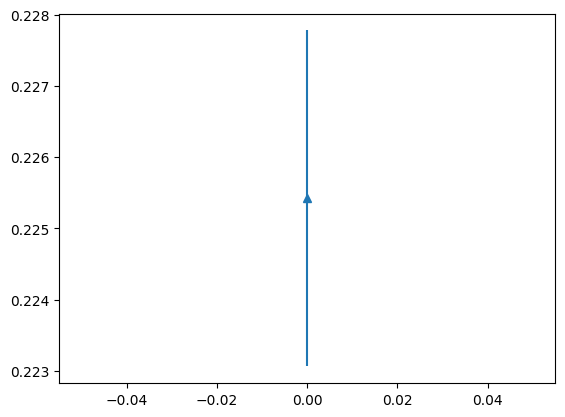

In [33]:
x, y, e = [], [], []

for vel in np.arange(0.1, 0.2, 0.1):
    x.append(float(key[:3]))
    y.append(float(np.mean(dic[key][0])))
    e.append(float(np.std(dic[key][0])))

plt.errorbar(x, y, e, linestyle='None', marker='^')

In [42]:
lol = np.where(np.logical_and(np.isclose(motion[:, 19], 0.1, 0.1))[0]
lol2 = np.where(np.logical_and(np.isclose(motion[:, 19], 0.1, 0.1))[0]

1.181134581565857 0.5689575672149658 1.0 0.0
1.2178934812545776 0.9475304484367371 1.1 0.0
1.185724139213562 0.6981861591339111 1.1 0.0
1.2099394798278809 0.9834970235824585 1.1 0.0
1.1645607948303223 0.7448077201843262 1.1 0.0
1.2400532960891724 0.6919618248939514 1.1 0.0
1.2165199518203735 0.9225663542747498 1.1 0.0
1.15878164768219 0.7797187566757202 1.1 0.0
1.1729233264923096 0.8402106165885925 1.1 0.0
1.2126638889312744 0.9577545523643494 1.1 0.0
1.2134153842926025 0.7659806609153748 1.1 0.0
1.247636318206787 0.8863247036933899 1.1 0.0
1.2055400609970093 0.8100267052650452 1.1 0.0
1.2332583665847778 1.0926856994628906 1.1 0.0
1.243822455406189 1.1859952211380005 1.1 0.0
1.1859952211380005 0.6089687347412109 0.0 0.0
1.1822102069854736 0.4842029809951782 0.0 0.0
1.1850875616073608 0.6747415661811829 0.0 0.0
1.17933189868927 1.1600606441497803 1.1 0.0
1.1600606441497803 0.7198618650436401 0.0 0.0
1.22678804397583 0.8891406059265137 1.1 0.0
1.1457581520080566 1.0959088802337646 1.1 0.

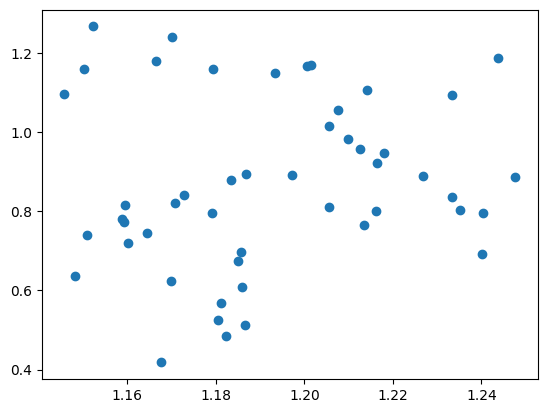

In [69]:
x_, y, e = [], [], []

for x in range(len(motion)):
    if x > 1:
        if np.isclose(motion[x-1, 19], 1.2, 0.05) and np.isclose(motion[x, 1], 0.0):
            print(motion[x-1, 19], motion[x, 19], motion[x-1, 1], motion[x, 1])
            x_.append(float(motion[x-1, 19]))
            y.append(float(motion[x, 19]))
            
plt.scatter(x_, y)

0.0 -> 0.0. Mean: -0.011. Std: 0.08
0.0 -> 0.1. Mean: 0.007. Std: 0.024
0.0 -> 0.2. Mean: 0.026. Std: 0.03
0.0 -> 0.3. Mean: 0.027. Std: 0.038
0.0 -> 0.4. Mean: 0.047. Std: 0.056
0.0 -> 0.5. Mean: 0.065. Std: 0.061
0.0 -> 0.6. Mean: 0.058. Std: 0.076
0.0 -> 0.7. Mean: 0.084. Std: 0.077
0.0 -> 0.8. Mean: 0.101. Std: 0.089
0.0 -> 0.9. Mean: 0.126. Std: 0.098


<ErrorbarContainer object of 3 artists>

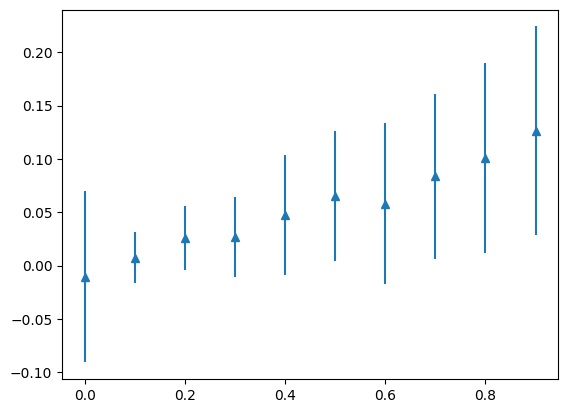

In [34]:
x, y, e = [], [], []

for vel in np.round(np.arange(0.0, 1.0, 0.1), 2):
    start = 0.0
    key = str(start)+str(vel)
    print(f"{start} -> {vel}. Mean: {np.round(np.mean(dic[key][0]), 3)}. Std: {np.round(np.std(dic[key][0]), 3)}")
    x.append(vel)
    y.append(float(np.mean(dic[key][0])))
    e.append(float(np.std(dic[key][0])))

plt.errorbar(x, y, e, linestyle='None', marker='^')

In [55]:
for x in range(len(e)):
    
    print(f"Accelerating from {0.0} to "
np.round(e, 3)

array([0.011, 0.012, 0.005, 0.008, 0.007, 0.007, 0.014, 0.008, 0.016,
       0.016])

In [54]:
np.round(y, 3)

array([0.009, 0.022, 0.041, 0.058, 0.072, 0.089, 0.097, 0.117, 0.123,
       0.139])